# Liquidity analysis

This is an example how to analyse [Automated Market Market liquidity](https://tradingstrategy.ai/glossary#amm) on a blockchain. It is similar of order book depth analysis on centralised exchanges.

We will

* Download pair and exchange map ("the trading universe")

* Plot a liquidity of a single trading pair on SushiSwap

* Compare the historical liquidity of all pairs on SushiSwap and Uniswap v2

* Calculate the slippage for a hypotethical trade that would have happened at a specific timepoint

## About liquidity data collection on AMM exchanges

Trading Strategy maintains the data of Uniswap v2 style, x*y = k bonding curve, liquidity in a similar format as it maintains OHLC price data. In more traditional finance, the equivalent analysis would be an order book depth - how much you can buy or sell and how much it would move the price.

For each [time bucket](https://tradingstrategy.ai/glossary#bucket) you get the available liquidity

* At open (start of the time bucket period)

* At close (end  of the time bucket period)

* At peak (high of the time bucket period)

* At bottom (low of the time bucket period)

The liquidity is expressed as the US dollar depth of the one side of the pool. E.g. the liquidity of a pool with 50 USDC and 0.001 ETH would be 50 USD.

There is also something very swap liquidity pool specific measurements

* Added and removed liquidity, as volume and as number of transactions

The liquidity data can be very effectively used to analyse or predict the trading fees of a swap.

[Read API documentation](../api/liquidity.rst)

## Getting started

First, let's create Trading Strategy dataset client.

In [1]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


## Fetching datasets

Get the map of exchanges and pairs we are working on

In [2]:
from pyarrow import Table
from tradingstrategy.exchange import ExchangeUniverse
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.liquidity import GroupedLiquidityUniverse

# Exchange map data is so small it does not need any decompression
exchange_universe: ExchangeUniverse = client.fetch_exchange_universe()

# Fetch all trading pairs across all exchanges
pair_table: Table = client.fetch_pair_universe()
pair_universe = PandasPairUniverse(pair_table.to_pandas())

# GroupedLiquidityUniverse is a helper class that
# encapsulates Pandas grouped array
liquidity_table: Table = client.fetch_all_liquidity_samples(TimeBucket.d1)
liquidity_universe = GroupedLiquidityUniverse(liquidity_table.to_pandas())

## Single pair liquidity

Here we first narrow down our data to single trading

In [3]:
from tradingstrategy.chain import ChainId
from tradingstrategy.pair import DEXPair

# Filter down to pairs that only trade on Sushiswap
sushi_swap = exchange_universe.get_by_chain_and_slug(ChainId.ethereum, "sushi")

pair: DEXPair = pair_universe.get_one_pair_from_pandas_universe(
    sushi_swap.exchange_id,
    "WETH",
    "USDC")

eth_usdc_liquidity = liquidity_universe.get_liquidity_samples_by_pair(pair.pair_id)

Let's create a table to explore the liquidity for a specific month

In [4]:
import datetime

start = datetime.datetime(2020, 10, 1)
end = datetime.datetime(2020, 11, 1)

df = eth_usdc_liquidity[["open", "high", "low", "close"]]

def format(x):
    return "${:.1f}M".format(x / 1_000_000)

df = df.applymap(format)

df[start:end]

,open,high,low,close
timestamp,,,,
2020-10-01,$24.1M,$28.3M,$13.2M,$14.6M
2020-10-02,$14.5M,$23.2M,$14.5M,$23.1M
2020-10-03,$23.1M,$23.4M,$22.3M,$22.7M
2020-10-04,$22.7M,$22.8M,$22.1M,$22.3M
2020-10-05,$22.3M,$22.4M,$16.9M,$17.1M
2020-10-06,$17.1M,$17.7M,$16.2M,$16.7M
2020-10-07,$16.7M,$16.7M,$15.1M,$16.3M
2020-10-08,$16.4M,$16.8M,$14.7M,$15.0M
2020-10-09,$15.0M,$19.5M,$15.0M,$19.4M


Now, let's plot how the liquidity has developed over the time. For OHLC liquidity values, we use high (peak) liquidity.

We also cut off the launch of the SushiSwap away from the time series, because the launch date was special due to SushiSwap's vampire attack on Uniswap liquidity (100x more liquidity available).

In [5]:
df = eth_usdc_liquidity[["close"]]

# Convert to millions
df["close"] = df["close"] / 1_000_00

/var/folders/12/pbc59svn70q_9dfz1kjl3zww0000gn/T/ipykernel_82533/112040287.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["close"] = df["close"] / 1_000_00


Let's plot the liquidity using Pandas internal plotting functions for Jupyter notebook

<AxesSubplot: title={'center': 'ETH-USDC liquidity on SushiSwap, all-time'}, xlabel='Day', ylabel='Liquidity (millions of  dollars)'>

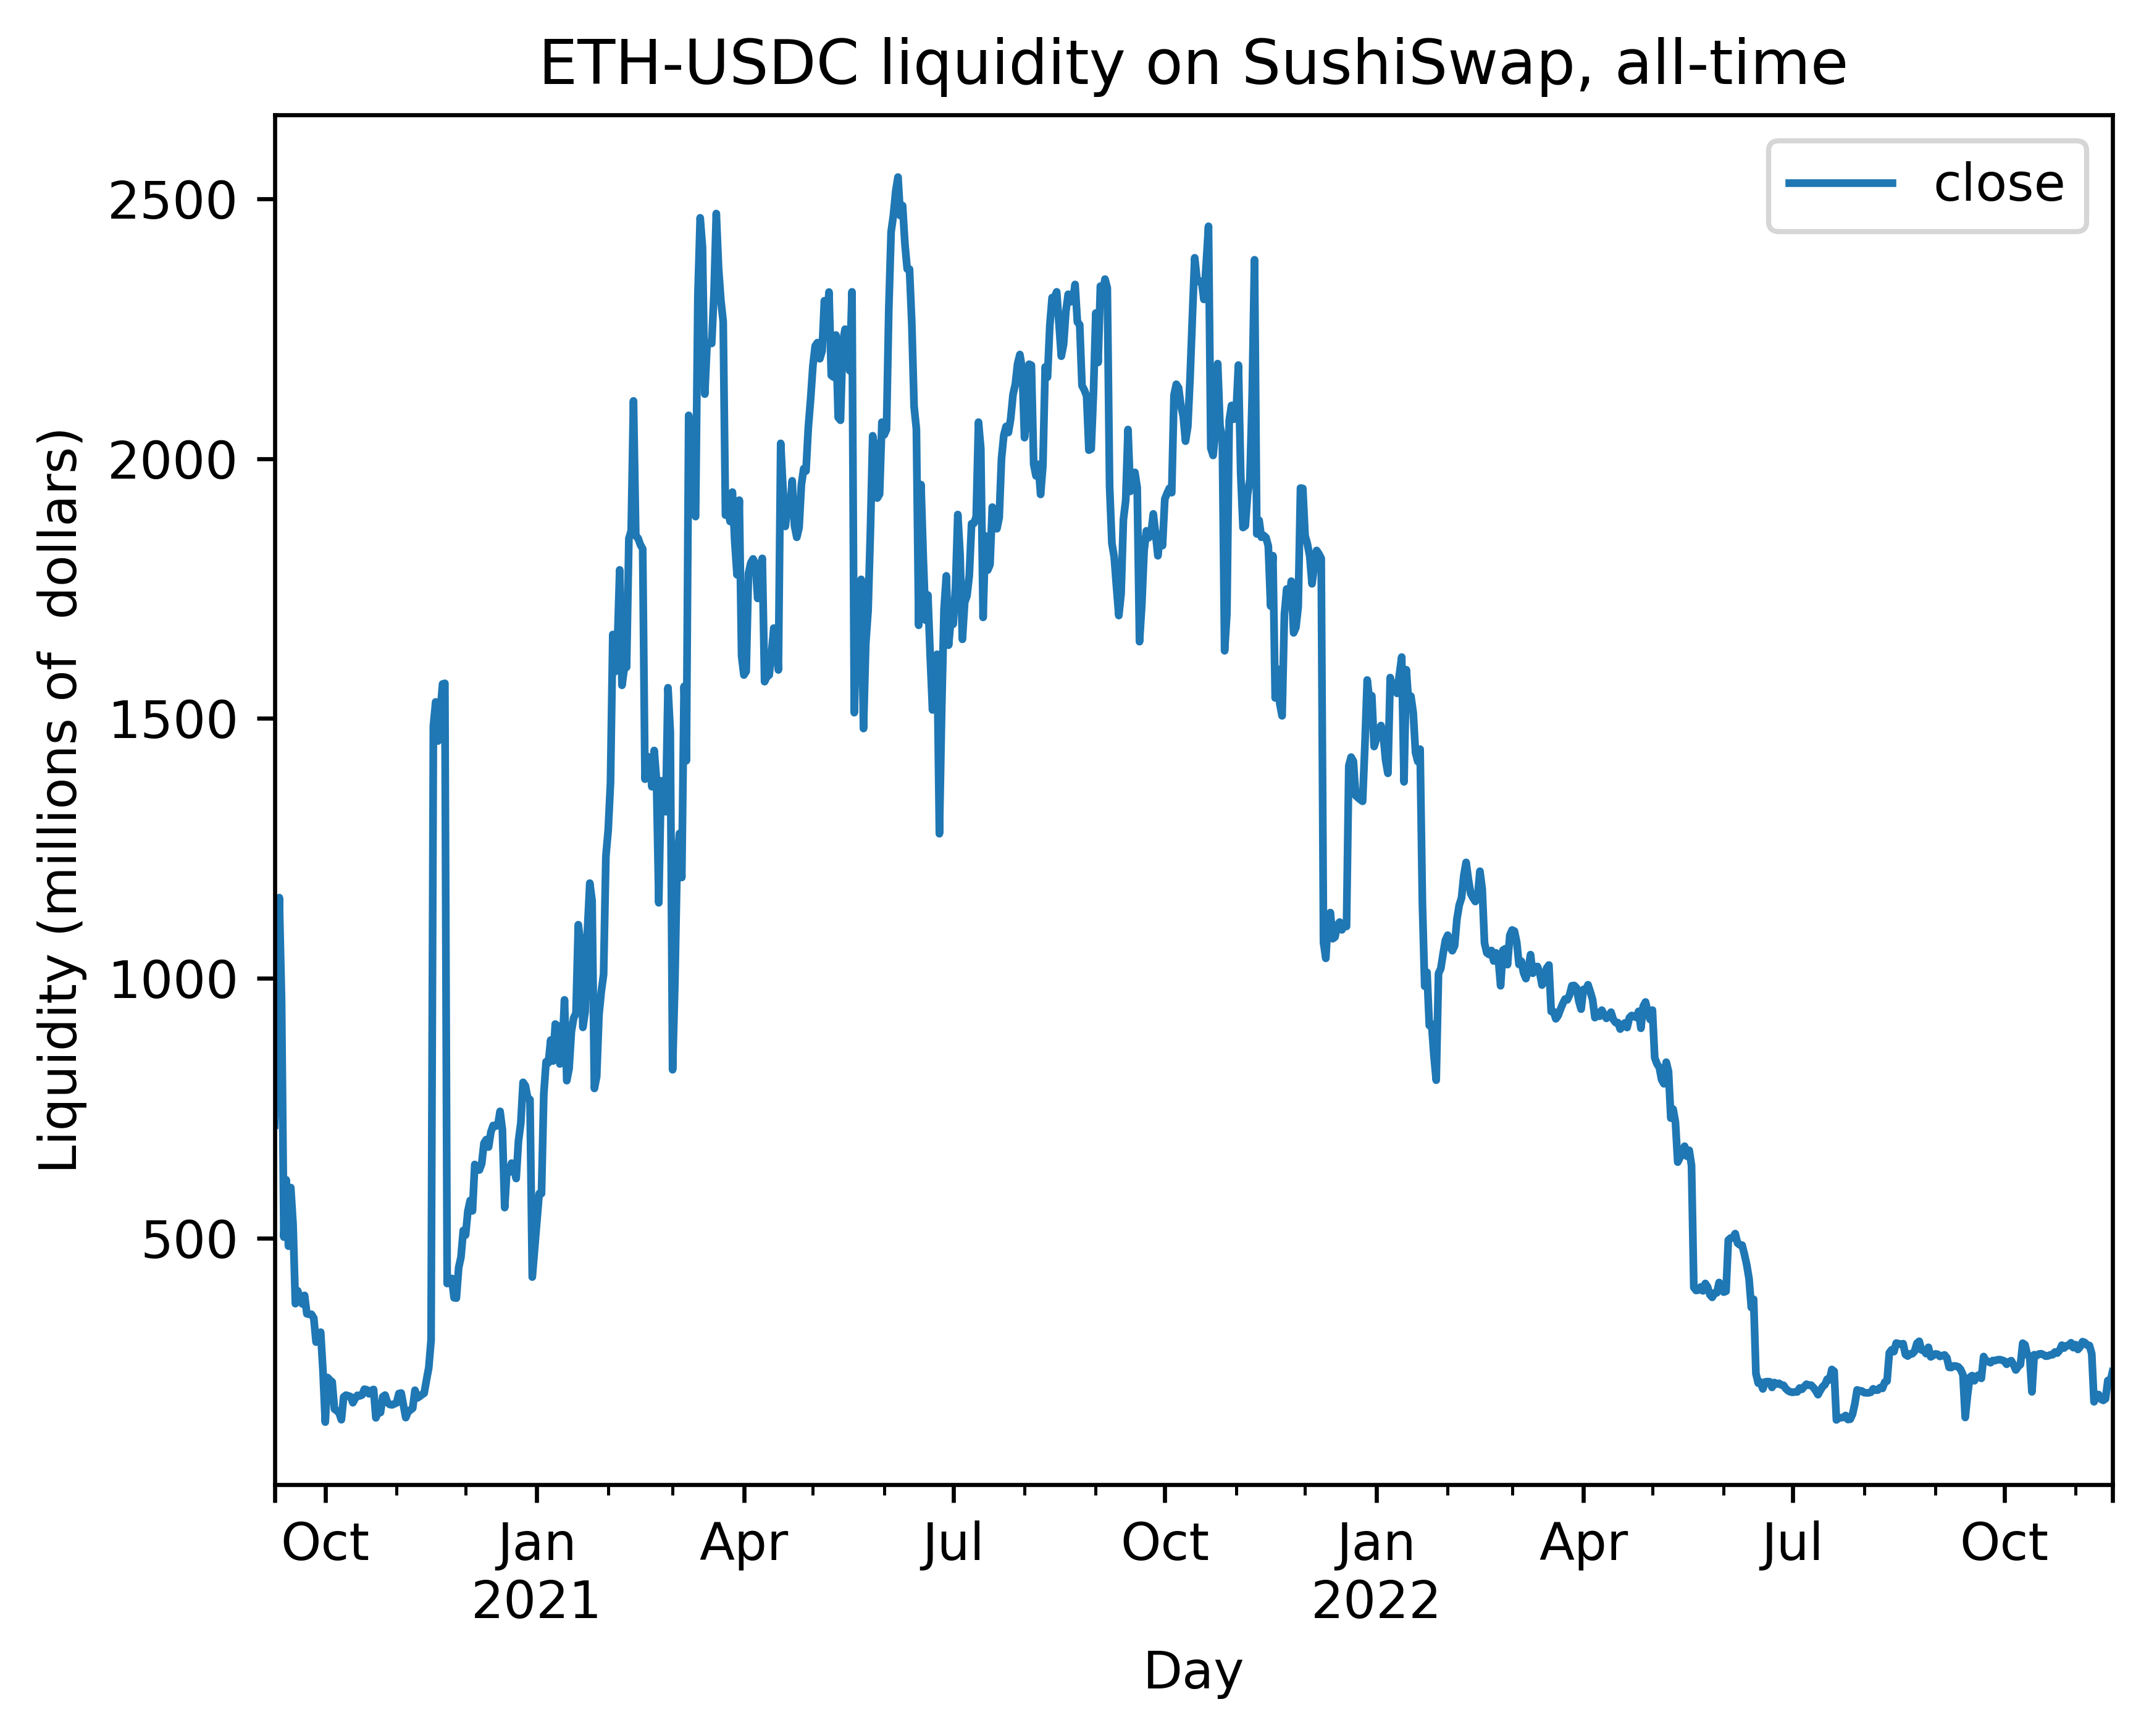

In [6]:
from tradingstrategy.frameworks.matplotlib import render_figure_in_docs

axes_subplot = df.plot(title="ETH-USDC liquidity on SushiSwap, all-time")
axes_subplot.set_xlabel("Day")
axes_subplot.set_ylabel("Liquidity (millions of  dollars)")

axes_subplot

## Comparing liquidity across exchanges

In this example, we compare the liquidity across Uniswap and Sushiswap for WETH-AAVE pair. We see that AAVE traders prefer Sushiswap.

In [7]:
import pandas as pd

uniswap_v2 = exchange_universe.get_by_chain_and_slug(ChainId.ethereum, "uniswap-v2")
sushi_swap = exchange_universe.get_by_chain_and_slug(ChainId.ethereum, "sushi")

pair1: DEXPair = pair_universe.get_one_pair_from_pandas_universe(
    sushi_swap.exchange_id,
    "AAVE",
    "WETH")

# Uniswap has fake listings for AAVE-WETH, and
# pick_by_highest_vol=True will work around this by
# using the highest volume pair of the same name.
# Usually the real pair has the highest volume and
# scam tokens have ~0 volume.
pair2: DEXPair = pair_universe.get_one_pair_from_pandas_universe(
    uniswap_v2.exchange_id,
    "AAVE",
    "WETH",
    pick_by_highest_vol=True)

liq1 = liquidity_universe.get_liquidity_samples_by_pair(pair1.pair_id)
liq2 = liquidity_universe.get_liquidity_samples_by_pair(pair2.pair_id)

Now construct a chart that shows the both liquidities, stacked.

<AxesSubplot: title={'center': 'AAVE-WETH liquidity, all-time'}, xlabel='Day', ylabel='Liquidity (millions of  dollars)'>

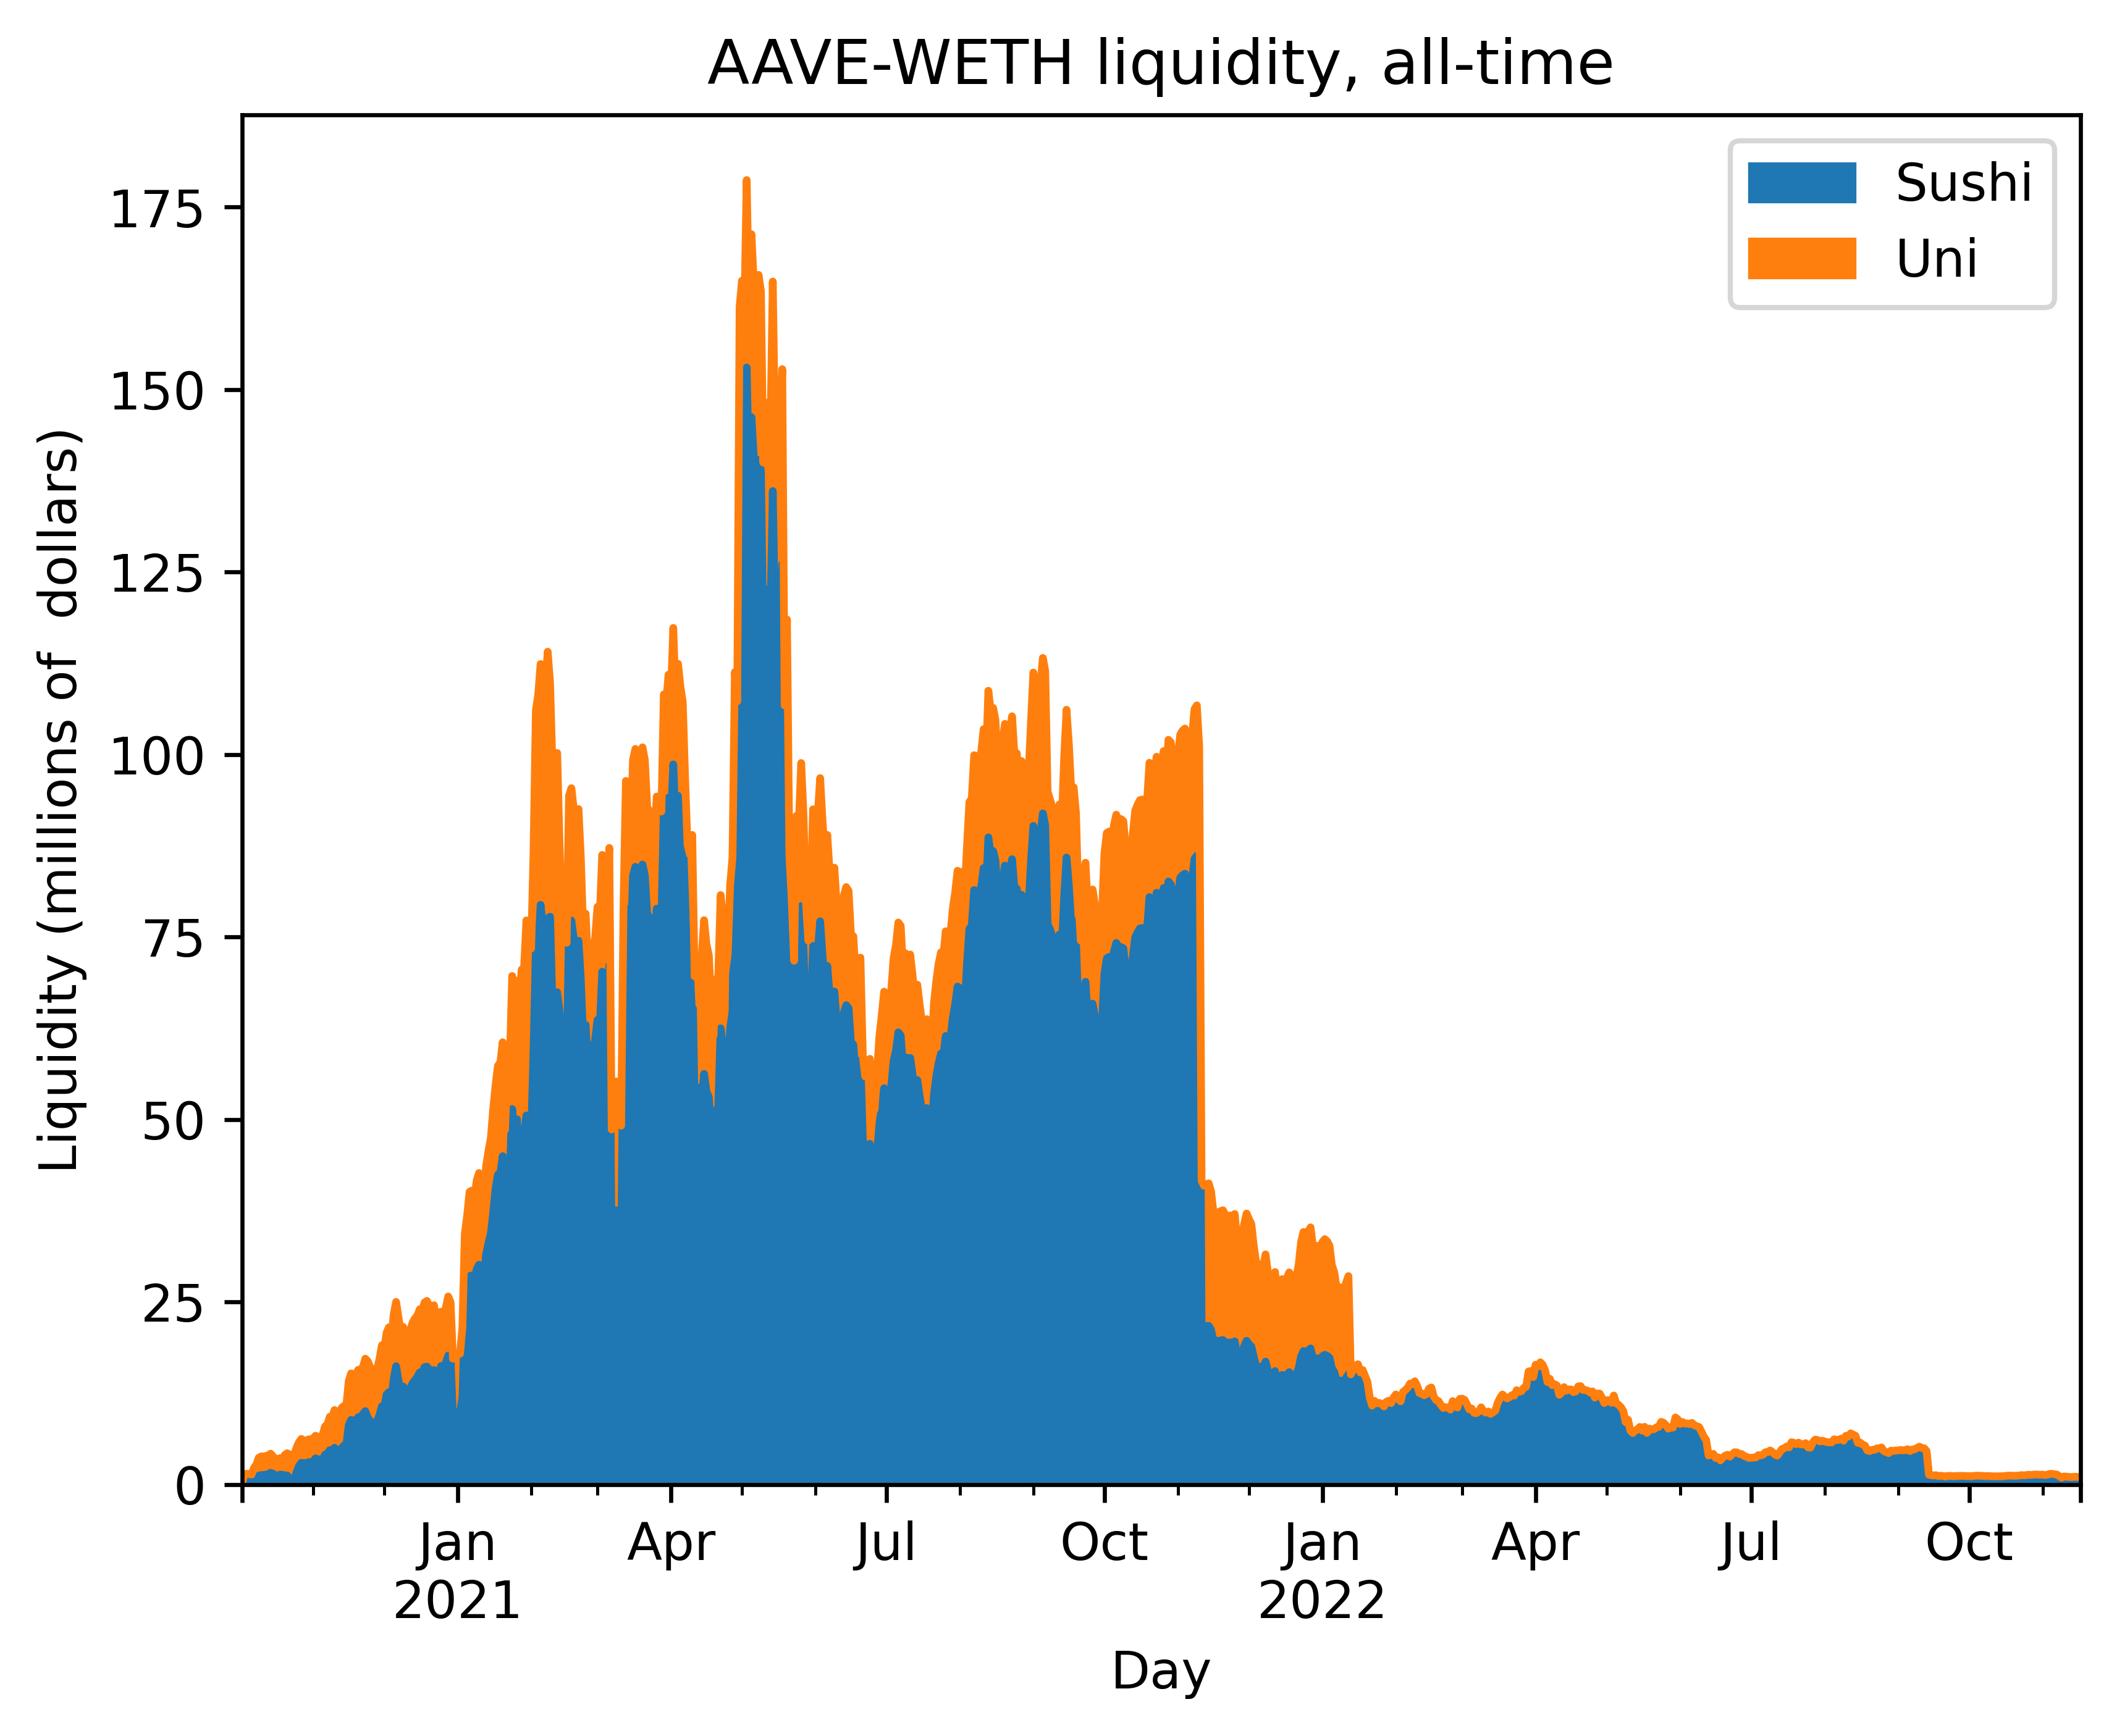

In [8]:
# Scale liquidity candles on the both series to $1M
sushi = liq1[["close"]] / 1_000_000
uni = liq2[["close"]] / 1_000_000

# Merge using timestamp index
df = pd.merge_ordered(sushi, uni, fill_method="ffill", on="timestamp")
df = df.set_index("timestamp")
df = df.rename(columns={"close_x": "Sushi", "close_y": "Uni"})

axes_subplot = df.plot.area(title="AAVE-WETH liquidity, all-time")
axes_subplot.set_xlabel("Day")
axes_subplot.set_ylabel("Liquidity (millions of  dollars)")

axes_subplot
